In [15]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import unittest
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5, context='talk')

import utils

In [256]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [257]:
class Pmf(pd.Series):
    
    @staticmethod
    def from_seq(seq):
        xs, ps = np.unique(seq, return_counts=True)
        ps = ps / np.sum(ps)
        return Pmf(ps, index=xs)
    
    @staticmethod
    def from_map(d):
        pmf = Pmf(d)
        pmf.sort()
        pmf.normalize()
        return pmf
    
    @property
    def xs(self):
        return self.index
    
    @property
    def ps(self):
        return self.values
    
    def __call__(self, qs):
        return self.get(qs, 0)
    
    def normalize(self):
        self /= self.sum()
        
    def sort(self):
        self.sort_index(inplace=True)
    
    def bar(self, **options):
        plt.bar(self.index, self.values, **options)
        
    def plot(self, **options):
        plt.plot(self.index, self.values, **options)

In [258]:
seq = [5, 3, 2, 2, 1]
pmf = Pmf.from_seq(seq)

1    0.2
2    0.4
3    0.2
5    0.2
dtype: float64

In [259]:
pmf(1)

0.2

In [260]:
pmf(2)

0.4

In [261]:
pmf(4)

0

In [262]:
c = Counter(seq)

Counter({5: 1, 3: 1, 2: 2, 1: 1})

In [263]:
pmf = Pmf.from_map(c)

1    0.2
2    0.4
3    0.2
5    0.2
dtype: float64

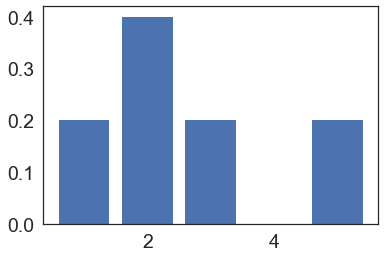

In [264]:
pmf.bar()

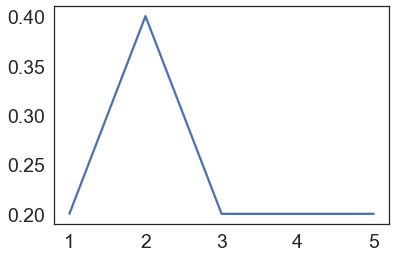

In [266]:
pmf.plot()

In [132]:
pmf.xs

Int64Index([1, 2, 3, 5], dtype='int64')

In [133]:
pmf.ps

array([0.2, 0.4, 0.2, 0.2])

In [277]:


def run_tests():
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

class TestPmf(unittest.TestCase):

    def test_pmf_from_seq(self):
        seq = [5, 3, 2, 2, 1]
        pmf = Pmf.from_seq(seq)
        self.assertEqual(pmf(1), 0.2)
        self.assertEqual(pmf(2), 0.4)
        self.assertEqual(pmf(4), 0.0)

    def test_pmf_from_map(self):
        seq = [5, 3, 2, 2, 1]
        c = Counter(seq)
        pmf = Pmf.from_map(c)
        self.assertEqual(pmf(1), 0.2)
        self.assertEqual(pmf(2), 0.4)
        self.assertEqual(pmf(4), 0.0)

    def test_pmf_from_series(self):
        qs = [5, 3, 2, 1]
        ps = [1, 1, 2, 1]
        pmf = Pmf(ps, index=qs)
        pmf.normalize()
        pmf.sort()
        self.assertEqual(pmf(1), 0.2)
        self.assertEqual(pmf(2), 0.4)
        self.assertEqual(pmf(4), 0.0)

    
run_tests()

...
----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


In [299]:
from scipy.interpolate import interp1d

class Cdf(pd.Series):
    
    @staticmethod
    def from_seq(seq):
        pmf = Pmf.from_seq(seq)
        return Cdf(pmf.cumsum())
    
    @staticmethod
    def from_map(d):
        pmf = Pmf.from_map(d)
        return Cdf(pmf.cumsum())
    
    @property
    def qs(self):
        return self.index
    
    @property
    def ps(self):
        return self.values
    
    @property
    def forward(self):
        return interp1d(cdf.qs, cdf.ps,
                          kind='previous',
                          assume_sorted=True,
                          bounds_error=False,
                          fill_value=(0,1))
    
    @property
    def inverse(self):
        return interp1d(cdf.ps, cdf.qs, 
                          kind='next',
                          assume_sorted=True,
                          bounds_error=False,
                          fill_value=(cdf.qs[0], np.nan))
    
    def __call__(self, qs):
        return self.forward(qs)
    
    def percentile_rank(self, qs):
        return self.forward(qs) * 100
    
    def percentile(self, percentile_ranks):
        return self.inverse(percentile_ranks / 100)
    
    def step(self, **options):
        underride(options, where='post')
        plt.step(self.index, self.values, **options)
    
    def plot(self, **options):
        plt.plot(self.index, self.values, **options)

In [300]:
cdf = Cdf.from_seq([5, 3, 2, 2, 1])

1    0.2
2    0.6
3    0.8
5    1.0
dtype: float64

In [301]:
cdf.qs

Int64Index([1, 2, 3, 5], dtype='int64')

In [302]:
cdf.ps

array([0.2, 0.6, 0.8, 1. ])

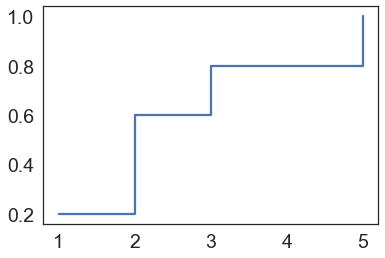

In [303]:
cdf.step()

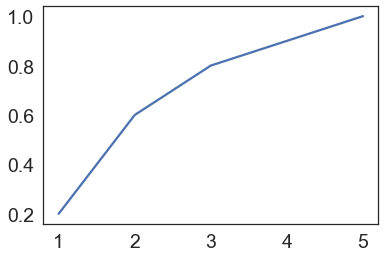

In [304]:
cdf.plot()

In [313]:
qs = [0, 1, 1.5, 2, 2.5, 3, 4, 5, 6]
cdf(qs)

array([0. , 0.2, 0.2, 0.6, 0.6, 0.8, 0.8, 1. , 1. ])

In [314]:
ps = np.linspace(0, 1, 6)


array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [315]:
cdf.inverse(ps)

array([1., 1., 2., 2., 3., 5.])

In [311]:
class TestPmf(unittest.TestCase):

    def test_pmf_from_seq(self):
        seq = [5, 3, 2, 2, 1]
        cdf = Cdf.from_seq(seq)
        self.assertAlmostEqual(cdf(0), 0)
        self.assertAlmostEqual(cdf(1), 0.2)
        self.assertAlmostEqual(cdf(2), 0.6)
        self.assertAlmostEqual(cdf(3), 0.8)
        self.assertAlmostEqual(cdf(4), 0.8)
        self.assertAlmostEqual(cdf(5), 1)
        self.assertAlmostEqual(cdf(6), 1)

    def test_pmf_from_map(self):
        seq = [5, 3, 2, 2, 1]
        c = Counter(seq)
        cdf = Cdf.from_map(c)
        res = cdf([0, 1, 2, 3, 4, 5, 6])
        expected = [0, 0.2, 0.6, 0.8, 0.8, 1, 1]
        self.assertTrue(np.abs(res-expected).max() < 1e12)
        
    def test_inverse(self):
        seq = [5, 3, 2, 2, 1]
        cdf = Cdf.from_seq(seq)
        self.assertAlmostEqual(cdf.inverse(0), 1)
        self.assertAlmostEqual(cdf.inverse(0.2), 1)
        self.assertAlmostEqual(cdf.inverse(0.3), 2)
        self.assertAlmostEqual(cdf.inverse(0.4), 2)
        self.assertAlmostEqual(cdf.inverse(0.41), 2)
        self.assertAlmostEqual(cdf.inverse(0.6), 2)
        self.assertAlmostEqual(cdf.inverse(0.8), 3)
        self.assertAlmostEqual(cdf.inverse(1), 5)
    
run_tests()

...
----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK
